In [1]:
# load dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# connect to CryptoCompare API
api_key = os.environ.get("CryptoCompare_API_KEY")

In [3]:
# retrieve a list of all coins
url = f"https://min-api.cryptocompare.com/data/all/coinlist"
response = requests.get(url).json()

# convert to dataframe
crypto_list_df = pd.DataFrame(response["Data"]).transpose()

In [4]:
# get full column list
crypto_list_df.columns

Index(['Id', 'Url', 'ImageUrl', 'ContentCreatedOn', 'Name', 'Symbol',
       'CoinName', 'FullName', 'Description', 'AssetTokenStatus', 'Algorithm',
       'ProofType', 'SortOrder', 'Sponsored', 'Taxonomy', 'Rating',
       'IsTrading', 'TotalCoinsMined', 'CirculatingSupply', 'BlockNumber',
       'NetHashesPerSecond', 'BlockReward', 'BlockTime', 'AssetLaunchDate',
       'AssetWhitepaperUrl', 'AssetWebsiteUrl', 'MaxSupply', 'MktCapPenalty',
       'IsUsedInDefi', 'IsUsedInNft', 'PlatformType', 'AlgorithmType',
       'Difficulty', 'BuiltOn', 'SmartContractAddress', 'DecimalPoints'],
      dtype='object')

In [5]:
# select only the needed columns
crypto_clean = crypto_list_df.loc[:, ["Name", "Symbol", "CoinName", "TotalCoinsMined", \
                                      "AssetLaunchDate", "MktCapPenalty"]]

# visualize the new pared-down dataframe
crypto_clean.head()

Name Symbol   CoinName TotalCoinsMined AssetLaunchDate MktCapPenalty
42    42     42    42 Coin       41.999952      2014-01-05             0
300  300    300  300 token             300      2017-07-01             0
365  365    365    365Coin               0      2017-11-17             0
404  404    404    404Coin               0      2017-10-31             0
433  433    433  433 Token             NaN             NaN           NaN

In [6]:
# investigate the number of coins available
len(crypto_clean)

8375

In [7]:
# investigate data types
crypto_clean.dtypes

Name               object
Symbol             object
CoinName           object
TotalCoinsMined    object
AssetLaunchDate    object
MktCapPenalty      object
dtype: object

In [8]:
def RetrieveDailyPrice(sym, comp_sym, all_data=True, exchange=''):
    url = "https://min-api.cryptocompare.com/data/v2/histoday?fsym={}&tsym={}&limit=2000"\
        .format(sym.upper(), comp_sym.upper())
    
    if exchange:
        url += f'&e={exchange}'
        
    url += f"&api_key={api_key}"
    
    response = requests.get(url)
    data = response.json()["Data"]
    
    if not data:
        return pd.DataFrame()
    
    crypto_df = pd.DataFrame(data["Data"])
        
    return crypto_df

In [9]:
cryp_dict = {}

ftx_collapse = pd.to_datetime("2022-11-11")
start = ftx_collapse - datetime.timedelta(days=14)
end = ftx_collapse + datetime.timedelta(days=14)

In [10]:
for sym in list(crypto_clean["Symbol"]):
    
    cur_sym_df = RetrieveDailyPrice(sym, "USD")
    
    if cur_sym_df.empty:
        continue
        
    else:
        cur_sym_df["time"] = pd.to_datetime(cur_sym_df["time"], unit='s')
        cur_sym_clean_df = cur_sym_df[["time", "open", "close", "low", "high"]]
        
        cur_sym_clean_df["return"] = (cur_sym_clean_df["close"] - 
                                      cur_sym_clean_df["open"]) / cur_sym_clean_df["open"]
        
        cur_sym_nar_df = cur_sym_clean_df.loc[(cur_sym_clean_df["time"] >= start) & 
                                              (cur_sym_clean_df["time"] <= end), :]
        
        if cur_sym_nar_df.empty:
            continue
            
        else:
            cryp_dict[sym] = [cur_sym_nar_df, cur_sym_nar_df["return"].mean()]

/var/folders/m6/5m5yr4vx1hnfwqqw70nydyqr0000gn/T/ipykernel_40579/2058860197.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_sym_clean_df["return"] = (cur_sym_clean_df["close"] -


KeyboardInterrupt: 

In [23]:
# create a dataframe and sort it by descending average daily return
# to retrieve the 25 best performing coins for the period of interest
avg_ret = [value[1] for value in cryp_dict.values()]

hi_ret_df = pd.DataFrame({"Symbol" : cryp_dict.keys(), 
                          "Coin Name" : [crypto_clean.loc[crypto_clean["Symbol"] == key, "CoinName"][0] for key in cryp_dict.keys()],
              "Average Daily Return" : [value[1] for value in cryp_dict.values()]
             }).sort_values("Average Daily Return", ascending=False).reset_index(drop=True).head(25)


ugh_list = ['MON', 'FBX', 'SFT', 'XBC', 'XSPC',
            'PHT', 'IPL', 'MPRO', 'DCK', 'SLS',
            'COSM', 'FLP', 'NZC', 'XTP', 'MERI',
            'DXO', 'BCDN', 'HXRO', 'CLINT', 'SUB',
           'ARCX', 'FIRE', 'ARPAC', 'QASH', 'ZCR']

pop_list = ['BTC', 'ETH', 'USDT', 'BNB', 'USDC',
            'XRP', 'BUSD', 'ADA', 'DOGE', 'MATIC',
            'SOL', 'DOT', 'LTC', 'SHIB', 'AVAX',
            'DAI', 'TRX', 'ATOM', 'LINK', 'ETC',
           'APT', 'BCH', 'APE', 'NEAR', 'FIL']

top_df = pd.DataFrame({"Symbol" : pop_list,
                       "Coin Name" : [crypto_clean.loc[crypto_clean["Symbol"] == key, "CoinName"][0] for key in pop_list]
                      })

In [35]:
ugh_ret = {}

for key in ugh_dict.keys():
    ugh_ret[key] = ugh_dict[key]["return"]
    
ugh_ret_df = pd.DataFrame(ugh_ret).fillna(0)

ugh_ret_df

MON       FBX       SFT       XBC      XSPC       PHT       IPL  \
1904   -0.995700  0.348387  0.000000  0.000000  0.014778  0.021142 -0.154351   
1905  208.656301 -0.896124  0.000000  0.000000  0.010402  0.041773  0.000000   
1906   -0.995035 -0.010594  0.000000  0.000000 -0.008922 -0.018131 -0.008646   
1907   -0.031447  0.001397  0.000000 -0.006558 -0.006925 -0.011364  0.000000   
1908   -0.052110  0.014877 -0.825482 -0.000574  0.000000 -0.642780  0.000000   
1909  197.150368 -0.009620  4.730059 -0.016083 -0.859484 -0.022926  0.000000   
1910   -0.995134  8.019426  0.000000  0.000000  0.002978  1.788927  0.000000   
1911  197.046181 -0.066667  0.000000  1.586026  8.421079 -0.617712  0.000000   
1912   -0.994735 -0.875934 -0.795596  0.000000  0.006828 -0.026062  0.006616   
1913  181.964225 -0.003543  3.898038  0.000000 -0.018258 -0.176016  0.000000   
1914    0.243017  7.133333  0.013747  0.000000 -0.781137  2.282415  0.000000   
1915   -0.217978 -0.053552  0.005037  0.000000 -0.099539 -0.149139 -0.099806   
1916   -0.974818 -0.882968  0.000000  0.000000 -0.573470 -0.167959  3.965646   
1917   41.639787 -0.012827 -0.042758  0.000000  0.109987 -0.678002  0.141132   
1918   -0.995682  7.430785  0.000000  0.000000 -0.031321  2.594277 -0.031321   
1919   -0.036769 -0.878720  0.000000  0.000000 -0.014109 -0.747451 -0.654909   
1920  188.534634  7.054741  0.000000  0.000000 -0.027430  2.672747  0.389267   
1921   -0.994688 -0.881917 -0.833374  0.000000  0.017167  0.029412 -0.084611   
1922  179.894569 -0.014388  5.242761  0.000000  0.017480 -0.724403 -0.434695   
1923   -0.994200 -0.023462 -0.850754  0.000000 -0.013626  2.552005  0.000000   
1924  161.687779  7.376935 -0.091945  0.000000  0.001802 -0.024402  0.000000   
1925   -0.993806 -0.883556  0.000000  0.000000  2.999400  0.033350 -0.855765   
1926  201.457695 -0.011494  0.000000  0.000000  1.001199  0.016137  5.028076   
1927   -0.995140 -0.015504  0.000000  0.000000 -0.026217 -0.056983 -0.458921   
1928   -0.045045  0.032058  0.000000  0.000000 -0.030000 -0.019316 -0.030393   
1929   -0.002144 -0.001090  9.393723  0.000000  0.156225  0.034343  0.000000   
1930    0.103137  0.002728  0.000000  0.000000 -0.089849  0.040527  0.843437   
1931    0.012076 -0.035909  0.000000  0.000000 -0.624943  0.027217  0.000000   
1932    0.003849 -0.041196 -0.903732  0.000000  0.990155 -0.003655  0.000000   

          MPRO       DCK       SLS  ...       DXO      BCDN      HXRO  \
1904  0.000000  0.026933  0.000000  ...  0.015028  0.166867  0.015470   
1905  0.000000  0.042301  0.000000  ... -0.494660 -0.166409 -0.008705   
1906  0.000000 -0.018669  0.000000  ...  0.981748  0.030855 -0.009330   
1907  0.000000 -0.011580  0.000000  ... -0.006544  0.176893 -0.006648   
1908  0.000000  0.004184  0.121237  ...  1.498170 -0.116734  0.005020   
1909  0.000000 -0.038333  0.004885  ... -0.015625  0.005471  0.006659   
1910  0.000000  0.007799  0.000000  ...  0.001984  0.008305  0.002756   
1911  0.000000  0.074807  0.000000  ...  0.047525 -0.065606  0.032435   
1912  0.000000 -0.010400  0.000000  ... -0.396030 -0.010638 -0.027689   
1913  0.000000 -0.036378  0.000000  ... -0.018310  0.060215 -0.018620   
1914  0.000000  0.000000 -0.014257  ... -0.343376  0.045204 -0.015067   
1915  0.000000 -0.149329  0.277066  ... -0.099539 -0.075132 -0.209065   
1916  0.000000 -0.172387 -0.146902  ... -0.146940 -0.238609 -0.153295   
1917  0.000000  0.173737  5.779822  ...  0.664981 -0.030709 -0.604822   
1918  0.000000 -0.008325 -0.048392  ... -0.031511 -0.008123  0.095911   
1919  0.000000 -0.023546 -0.599647  ... -0.342415  0.027846 -0.125024   
1920  0.000000 -0.027993 -0.027900  ...  1.430402  0.020717 -0.060728   
1921  0.000000  0.017690  0.283233  ...  0.017415 -0.030835 -0.735679   
1922  0.307400  0.008479 -0.044732  ...  0.017358 -0.092227  0.017086   
1923  7.218750 -0.029322  0.000000  ... -0.013744 -0.029725  4.887710   
1924 -0.027376 -0.012993  0.000000  ...  0.001922  0.042067 -0.661811   
1925  

In [36]:
import scipy.stats as stats

stats.f_oneway(ugh_ret_df['MON'], ugh_ret_df['FBX'], ugh_ret_df['SFT'], ugh_ret_df['XBC'], ugh_ret_df['XSPC'],
              ugh_ret_df['PHT'], ugh_ret_df['IPL'], ugh_ret_df['MPRO'], ugh_ret_df['DCK'], ugh_ret_df['SLS'],
              ugh_ret_df['COSM'], ugh_ret_df['FLP'], ugh_ret_df['NZC'], ugh_ret_df['XTP'], ugh_ret_df['MERI'],
              ugh_ret_df['DXO'], ugh_ret_df['BCDN'], ugh_ret_df['HXRO'], ugh_ret_df['CLINT'], ugh_ret_df['SUB'],
              ugh_ret_df['ARCX'], ugh_ret_df['FIRE'], ugh_ret_df['ARPAC'], ugh_ret_df['QASH'], ugh_ret_df['ZCR'])

F_onewayResult(statistic=10.994712928232117, pvalue=4.903007814141329e-35)

In [15]:
hi_ret_df

Symbol Coin Name  Average Daily Return
0    404   404Coin              0.000000
1    888  Octocoin             -0.006168
2    365   365Coin             -0.016903

In [16]:
top_df

Symbol         Coin Name
0     BTC           Bitcoin
1     ETH          Ethereum
2    USDT            Tether
3     BNB      Binance Coin
4    USDC          USD Coin
5     XRP               XRP
6    BUSD              BUSD
7     ADA           Cardano
8    DOGE          Dogecoin
9   MATIC           Polygon
10    SOL            Solana
11    DOT          Polkadot
12    LTC          Litecoin
13   SHIB         Shiba Inu
14   AVAX         Avalanche
15    DAI               Dai
16    TRX              TRON
17   ATOM            Cosmos
18   LINK         Chainlink
19    ETC  Ethereum Classic
20    APT             Aptos
21    BCH      Bitcoin Cash
22    APE           ApeCoin
23   NEAR              Near
24    FIL          FileCoin

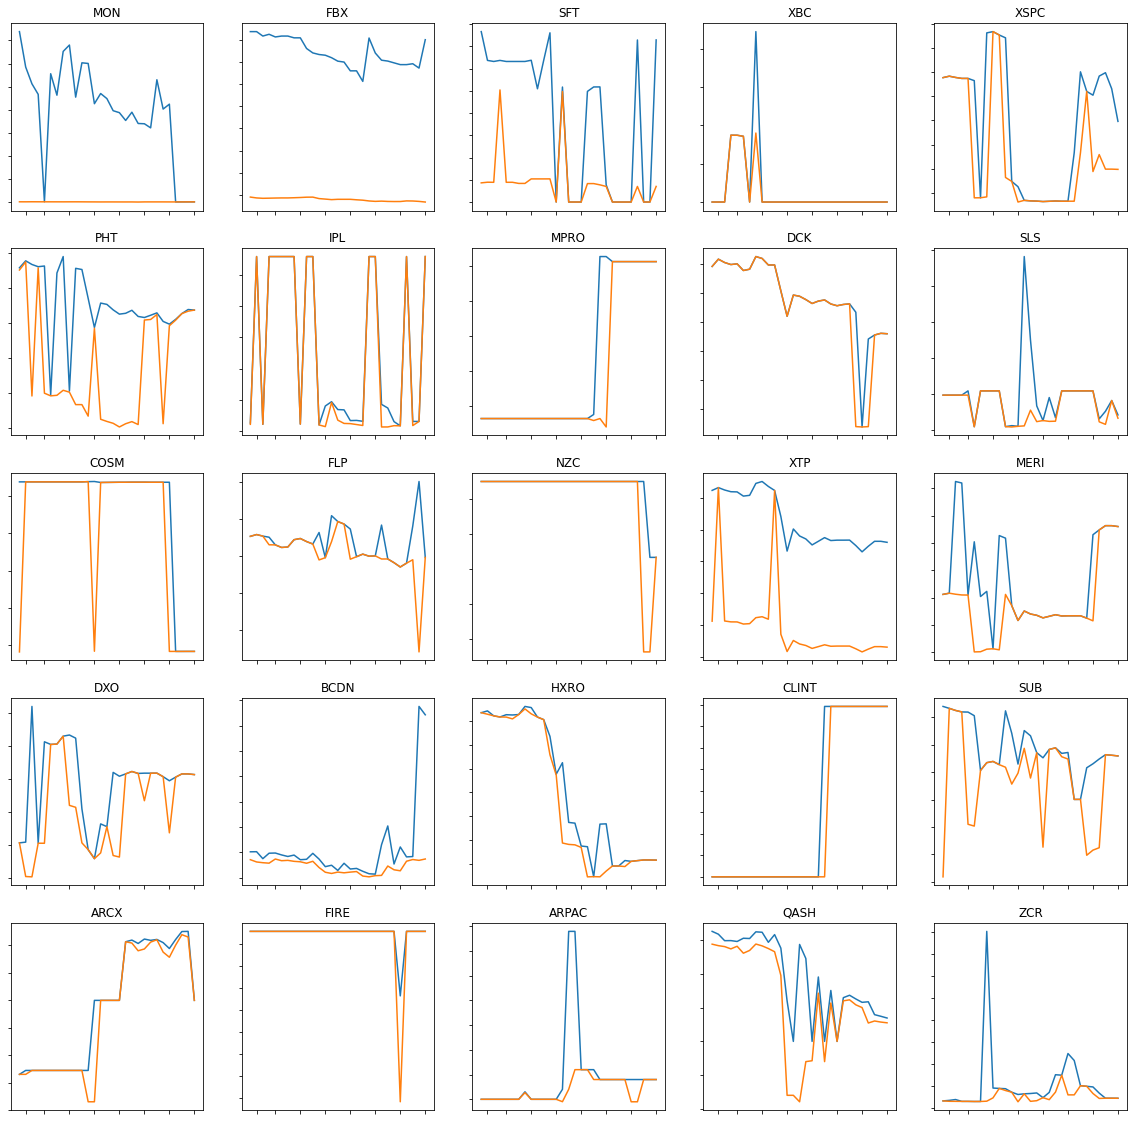

In [74]:
# initiate the figure and axis with 23 subplots in a vertical line
fig, ax = plt.subplots(5,5, figsize=(20, 20))

i = 0
j = 0

for sym in hi_ret_df["Symbol"]:
    
    ax[i, j].plot(cryp_dict[sym][0]["time"], cryp_dict[sym][0]["high"])
    ax[i, j].plot(cryp_dict[sym][0]["time"], cryp_dict[sym][0]["low"])
    ax[i, j].set_title(sym)
    ax[i, j].tick_params(which='both',      # both major and minor ticks are affected
                         right=False,
                         left=True,
                         bottom=True,      # ticks along the bottom edge are off
                         top=False,         # ticks along the top edge are off
                         labelbottom=False,
                         labelleft=False)
    
    if j < 4:
        j += 1
    else:
        i += 1
        j = 0

In [18]:
top_dict = {}

for sym in list(pop_list):
    
    cur_sym_df = RetrieveDailyPrice(sym, "USD")
    
    if cur_sym_df.empty:
        continue
        
    else:
        cur_sym_df["time"] = pd.to_datetime(cur_sym_df["time"], unit='s')
        cur_sym_clean_df = cur_sym_df[["time", "open", "close", "low", "high"]]
        
        cur_sym_clean_df["return"] = (cur_sym_clean_df["close"] - 
                                      cur_sym_clean_df["open"]) / cur_sym_clean_df["open"]
        
        cur_sym_nar_df = cur_sym_clean_df.loc[(cur_sym_clean_df["time"] >= start) & 
                                              (cur_sym_clean_df["time"] <= end), :]
        
        if cur_sym_nar_df.empty:
            continue
            
        else:
            top_dict[sym] = cur_sym_nar_df

/var/folders/m6/5m5yr4vx1hnfwqqw70nydyqr0000gn/T/ipykernel_40579/2714029701.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_sym_clean_df["return"] = (cur_sym_clean_df["close"] -


In [29]:
ugh_dict = {}

for sym in list(ugh_list):
    
    cur_sym_df = RetrieveDailyPrice(sym, "USD")
    
    if cur_sym_df.empty:
        continue
        
    else:
        cur_sym_df["time"] = pd.to_datetime(cur_sym_df["time"], unit='s')
        cur_sym_clean_df = cur_sym_df[["time", "open", "close", "low", "high"]]
        
        cur_sym_clean_df["return"] = (cur_sym_clean_df["close"] - 
                                      cur_sym_clean_df["open"]) / cur_sym_clean_df["open"]
        
        cur_sym_nar_df = cur_sym_clean_df.loc[(cur_sym_clean_df["time"] >= start) & 
                                              (cur_sym_clean_df["time"] <= end), :]
        
        if cur_sym_nar_df.empty:
            continue
            
        else:
            ugh_dict[sym] = cur_sym_nar_df

/var/folders/m6/5m5yr4vx1hnfwqqw70nydyqr0000gn/T/ipykernel_40579/4013510343.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
top_dict

{'BTC':            time      open     close       low      high    return
 1904 2022-10-28  20295.28  20599.89  20031.32  20751.67  0.015009
 1905 2022-10-29  20599.89  20820.19  20564.11  21064.84  0.010694
 1906 2022-10-30  20820.19  20630.65  20523.41  20936.41 -0.009104
 1907 2022-10-31  20630.65  20492.56  20242.91  20833.31 -0.006693
 1908 2022-11-01  20492.56  20480.27  20336.33  20684.60 -0.000600
 1909 2022-11-02  20480.27  20150.33  20061.18  20801.56 -0.016110
 1910 2022-11-03  20150.33  20207.99  20040.32  20385.92  0.002861
 1911 2022-11-04  20207.99  21150.60  20182.90  21295.37  0.046645
 1912 2022-11-05  21150.60  21301.57  21085.76  21471.49  0.007138
 1913 2022-11-06  21301.57  20910.59  20893.65  21363.27 -0.018355
 1914 2022-11-07  20910.59  20593.73  20395.49  21066.63 -0.015153
 1915 2022-11-08  20593.73  18544.70  17452.87  20672.25 -0.099498
 1916 2022-11-09  18544.70  15820.02  15546.97  18581.64 -0.146925
 1917 2022-11-10  15820.02  17559.67  15674.81  18113.2

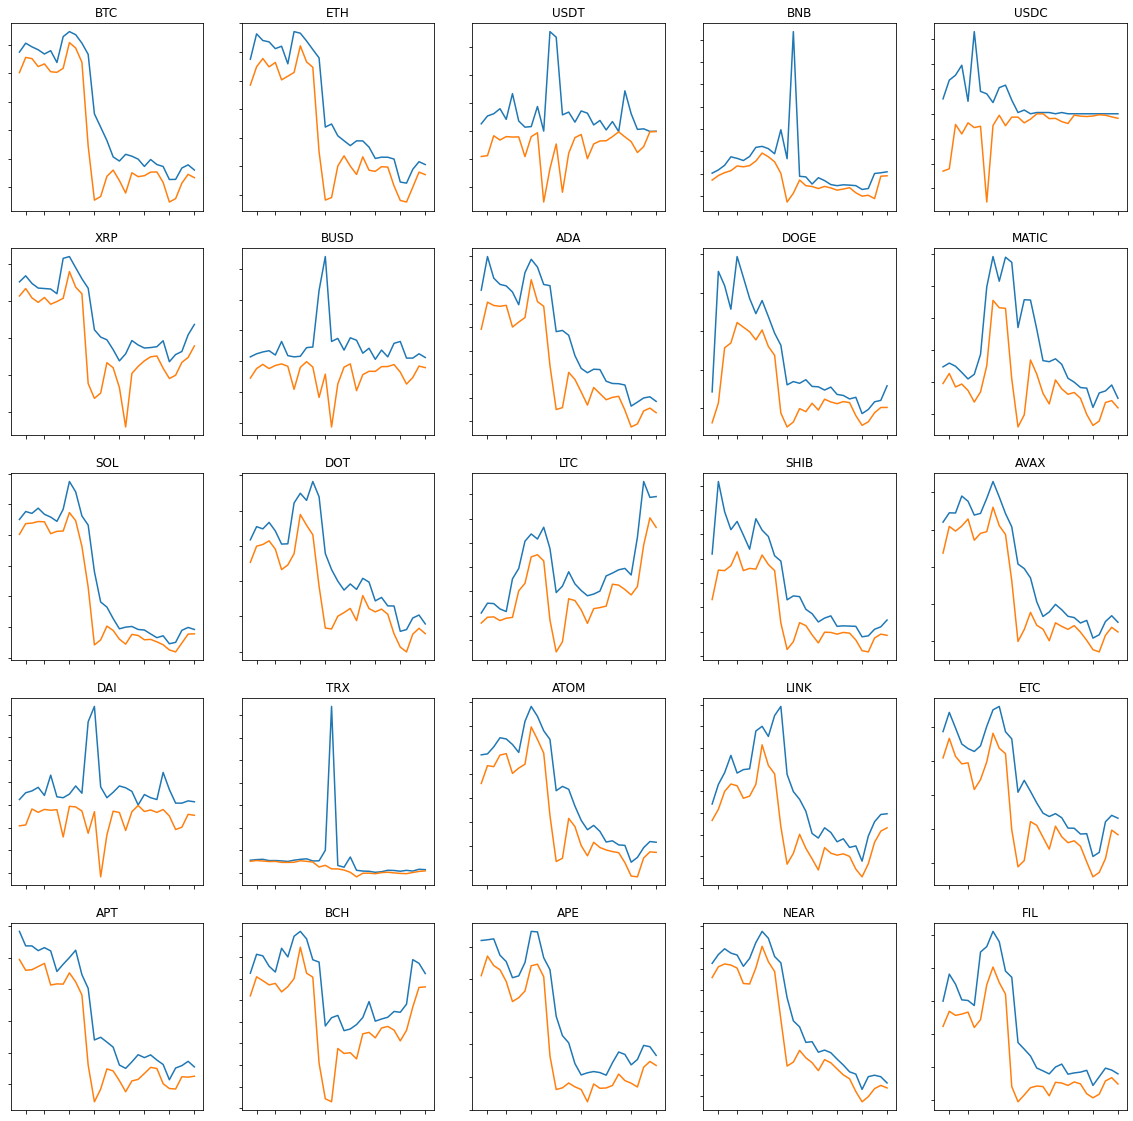

In [21]:
# initiate the figure and axis with 23 subplots in a vertical line
fig, ax = plt.subplots(5,5, figsize=(20, 20))

i = 0
j = 0

for sym in top_df["Symbol"]:
    
    ax[i, j].plot(top_dict[sym]["time"], top_dict[sym]["high"])
    ax[i, j].plot(top_dict[sym]["time"], top_dict[sym]["low"])
    ax[i, j].set_title(sym)
    ax[i, j].tick_params(which='both',      # both major and minor ticks are affected
                         right=False,
                         left=True,
                         bottom=True,      # ticks along the bottom edge are off
                         top=False,         # ticks along the top edge are off
                         labelbottom=False,
                         labelleft=False)
    
    if j < 4:
        j += 1
    else:
        i += 1
        j = 0

In [22]:
for sym in pop_list:
    
    fig = go.Figure(data=[go.Candlestick(x=top_dict[sym]["time"],
                                 open=top_dict[sym]["open"], high=top_dict[sym]["high"],
                                 low=top_dict[sym]["low"], close=top_dict[sym]["close"])], 
                    layout={'title' : f"{sym} : {crypto_clean.loc[crypto_clean['Symbol'] == sym, 'CoinName'][0]}"})
    
    fig.show()

In [132]:
top_ret = {}

for key in top_dict.keys():
    top_ret[key] = top_dict[key]["return"]
    
top_ret_df = pd.DataFrame(top_ret)

top_ret_df.head()

BTC       ETH      USDT       BNB    USDC       XRP  BUSD  \
1904  0.015009  0.026922  0.000000  0.038822 -0.0002  0.027507   0.0   
1905  0.010694  0.041990  0.001000  0.021973  0.0005 -0.008642   0.0   
1906 -0.009104 -0.018199 -0.000999  0.029838  0.0000 -0.025728   0.0   
1907 -0.006693 -0.011346 -0.000200  0.037803 -0.0004  0.013749   0.0   
1908 -0.000600  0.003579 -0.000100 -0.005221  0.0002 -0.002153   0.0   

           ADA      DOGE     MATIC  ...     DAI       TRX      ATOM      LINK  \
1904  0.041720  0.090779  0.045480  ... -0.0002  0.009530  0.070356  0.031916   
1905  0.039555  0.452248 -0.011537  ...  0.0006  0.011485 -0.005170  0.073809   
1906 -0.034958 -0.033662 -0.027091  ... -0.0004 -0.018510  0.034150  0.019115   
1907 -0.000493  0.078165 -0.006273  ... -0.0001  0.002536  0.027997  0.009507   
1908 -0.010848  0.120567 -0.032008  ...  0.0002 -0.007588 -0.016760 -0.022016   

           ETC       APT       BCH       APE      NEAR       FIL  
1904  0.029899 -0.059297  0.028460  0.077373  0.020925  0.024647  
1905  0.014908 -0.029441  0.025770 -0.009857  0.020496  0.065635  
1906 -0.052184 -0.017621 -0.020148 -0.026412  0.004859 -0.056693  
1907 -0.010604  0.017681 -0.009722 -0.012312  0.001612  0.006307  
1908 -0.009068  0.031348 -0.000869 -0.048172 -0.030576 -0.011060  

[5 rows x 25 columns]

<AxesSubplot:>

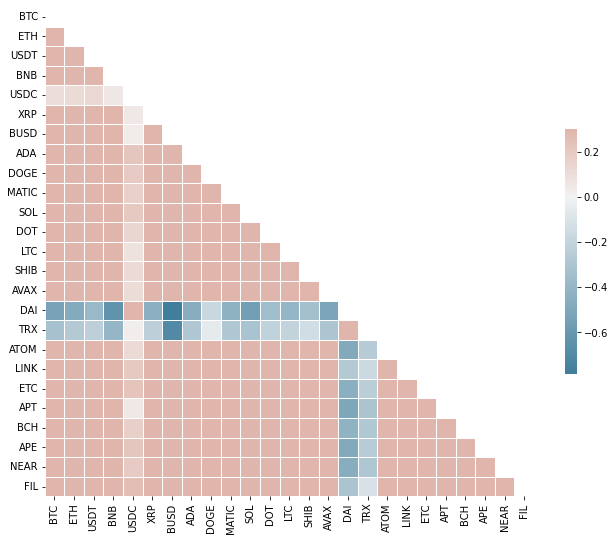

In [133]:
# Compute the correlation matrix
corr = top_ret_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5})

<AxesSubplot:>

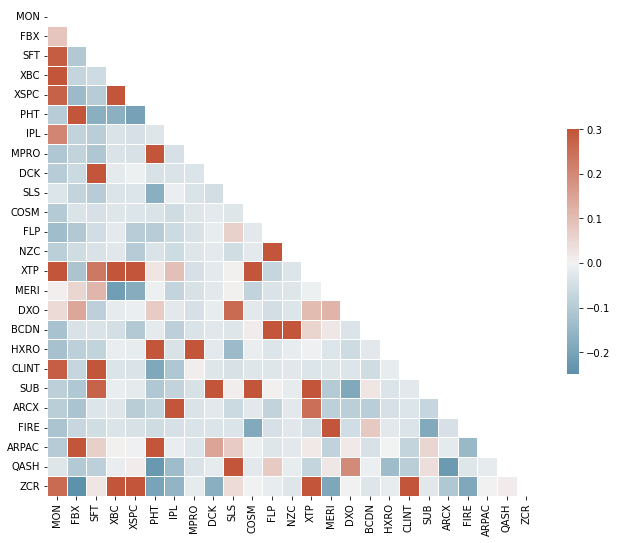

In [37]:
# Compute the correlation matrix
corr = ugh_ret_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5})

In [129]:
import scipy.stats as stats
    
stats.f_oneway(top_ret_df['BTC'], top_ret_df['ETH'], top_ret_df['USDT'], top_ret_df['BNB'], top_ret_df['USDC'],
              top_ret_df['XRP'], top_ret_df['BUSD'], top_ret_df['ADA'], top_ret_df['DOGE'], top_ret_df['MATIC'],
              top_ret_df['SOL'], top_ret_df['DOT'], top_ret_df['LTC'], top_ret_df['SHIB'], top_ret_df['AVAX'],
              top_ret_df['DAI'], top_ret_df['TRX'], top_ret_df['ATOM'], top_ret_df['LINK'], top_ret_df['ETC'],
              top_ret_df['APT'], top_ret_df['BCH'], top_ret_df['APE'], top_ret_df['NEAR'], top_ret_df['FIL'])

F_onewayResult(statistic=0.36291422643053617, pvalue=0.9980077195843696)